In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import torch
import json
op = os.path
from post_process import *
from jax import jit
from post_process import compare_dataframes, plot_available_data, export_weights, read_airfoil_data, get_model

# Airfoil data

In [3]:
e231, e231_cd, e231_cm = read_airfoil_data('data/e231.csv')

In [4]:
e231.head()

,alpha,Cl,Cd,Cm,Re
260,-4.57,-0.452,0.0276,NaN,60800
261,-3.53,-0.363,0.0219,NaN,60800
245,-2.51,-0.223,0.0197,NaN,60900
246,-1.44,-0.124,0.0204,NaN,60900
247,-0.44,-0.021,0.0230,NaN,60900


Source : https://m-selig.ae.illinois.edu/pd/pub/lsat/vol3/

<u> Batch 1 </u>: $C_L$ and $C_m$ only

{{len(e231_cm)}} measurements

Alpha range: {{e231_cm.alpha.min(), e231_cm.alpha.max()}}

Re range: {{e231_cm.Re.min(), e231_cm.Re.max()}}

<u> Batch 2 </u>: $C_L$ and $C_D$ only

{{len(e231_cd)}} measurements

Alpha range: {{e231_cd.alpha.min(), e231_cd.alpha.max()}}

Re range: {{e231_cd.Re.min(), e231_cd.Re.max()}}

### Notes
- No post stall data for drag

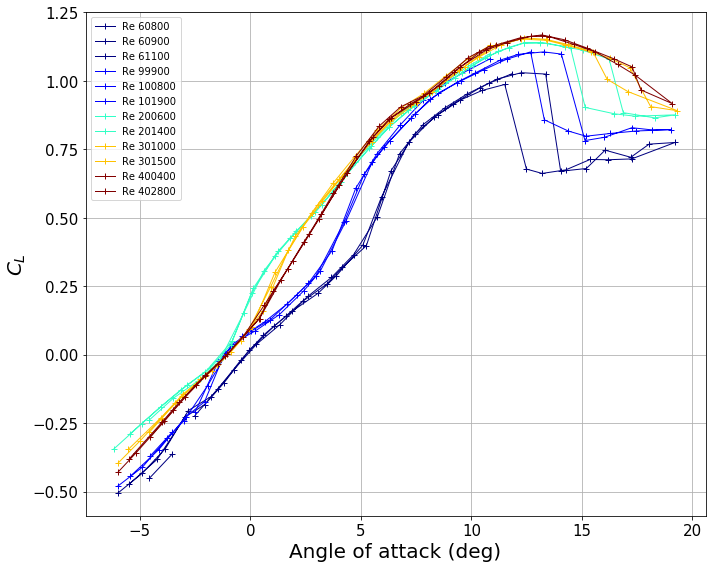

In [14]:
plot_available_data(e231, "Cl", "$C_L$");

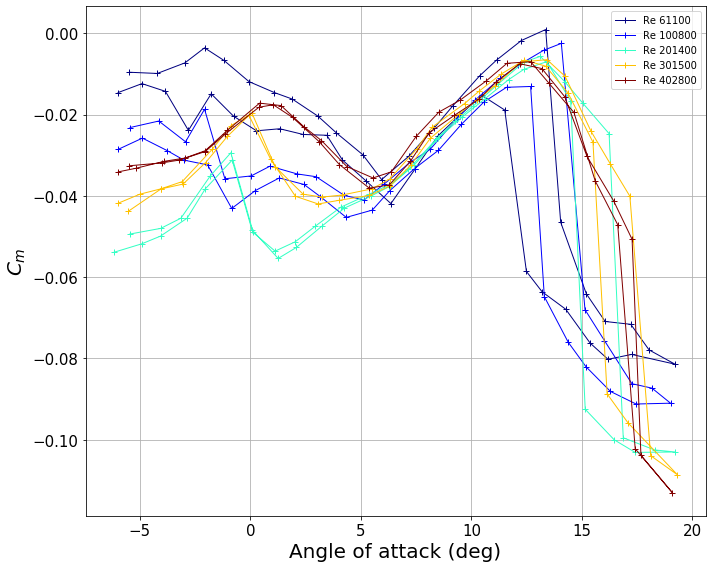

In [8]:
plot_available_data(e231, "Cm", "$C_m$");

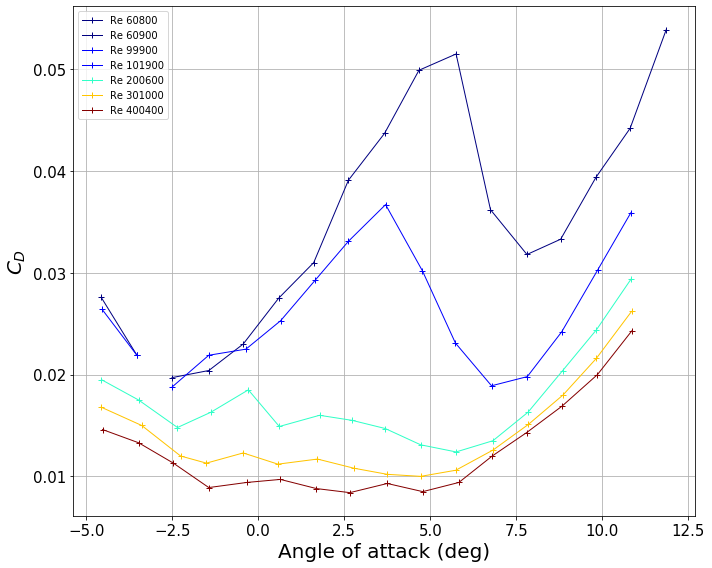

In [9]:
plot_available_data(e231, "Cd", "$C_D$");

In [10]:
e231_cd['logCd'] = np.log(e231_cd.Cd)
e231_cd['expCl'] = np.exp(e231_cd.Cl)


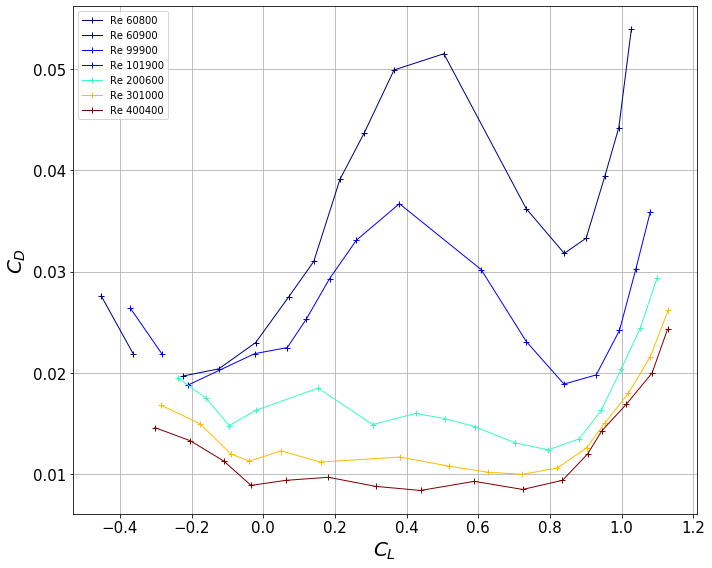

In [11]:
f = plot_available_data(e231_cd, xcol="Cl", xcolname="$C_L$",ycol="Cd", ycolname="$C_D$"); f.savefig("images/dataCd_Cl", dpi=100)

In [12]:
e231_cd_ = e231_cd[e231_cd["Cl"]>0]

In [13]:
e231_cd_['logCd'] = np.log(e231_cd['Cd'])
e231_cd_['logCl'] = np.log(e231_cd['Cl'])
e231_cd_['Re'] = np.log(e231_cd['Re'])

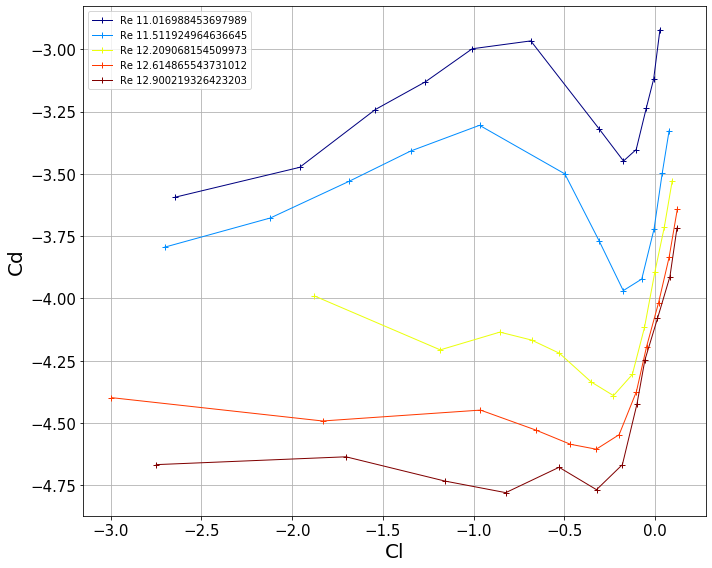

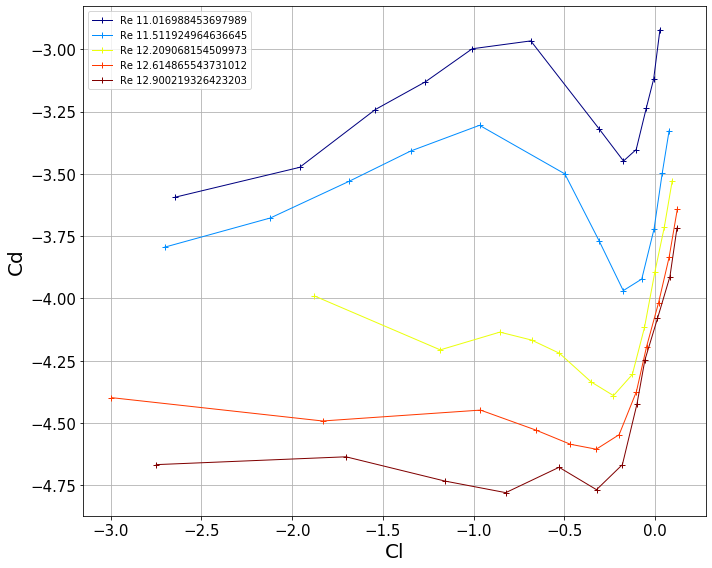

In [14]:
plot_available_data(e231_cd_, "logCd", "Cd", "logCl", "Cl")

In [2]:
model_name = "Mar17_06-15-11_adgboost_0_2"
get_model(model_name, 'abq')

NameError: name 'get_model' is not defined

# Compare with NN fit

In [3]:
model_name = "Mar17_06-15-11_adgboost_0_2"
with open(op.join("abq/models", model_name+'.json'), "r") as f:
    params = json.load(f)
model = build_model(params["hidden_layers"])
model.load_state_dict(torch.load(op.join("abq/models", model_name + ".mdl")))

FileNotFoundError: [Errno 2] No such file or directory: 'abq/models/Mar17_06-15-11_adgboost_0_2.json'

## Prediction on training data

In [ ]:
_, _, inp, out, msk, inp_mean, out_mean, inp_std, out_std, _ = load_data("e231.csv", params)
with torch.no_grad():
    inp_data = (inp * inp_std + inp_mean).data
    out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "alpha":inp_data[:,0],
    "Cl":out_data[:,0],
    "Cd":out_data[:,1],
    "Cm":out_data[:,2], 
    "Re":inp_data[:,1]
})

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cl', "$C_L$", colorbar=True);

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cd', "$C_D$", colorbar=True);

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cm', "$C_M$", colorbar=True);

## Predict on new data

In [ ]:
al = torch.linspace(-5, 20, 100)
Re = torch.linspace(70000, 400000, 10)
inp = (torch.stack(torch.meshgrid([al, Re]), -1).view(-1,2) - inp_mean)/inp_std


In [ ]:
plot_available_data(pred, 'Cl', "$C_L$", style='-', colorbar=True);

In [ ]:
plot_available_data(pred, 'Cd', "$C_D$", style='-', colorbar=True);

In [ ]:
plot_available_data(pred, 'Cm', "$C_m$", style='-', colorbar=True);

# Fit and show drag polar

In [5]:
ls polar/models

Apr17_09-43-39_jeandb.json        Apr17_11-44-24_jeandb.mdl
Apr17_09-43-39_jeandb.mdl         Mar18_06-53-35_adgboost_1_1.json
Apr17_11-44-24_jeandb.json        Mar18_06-53-35_adgboost_1_1.mdl


In [12]:
model = get_model('Apr17_11-44-24_jeandb', 'polar')

In [13]:
model = jit(model)

In [14]:
pred = e231_cd.copy()
pred['Cd'] = model(pred['Cl'].values, pred['Re'].values).squeeze()

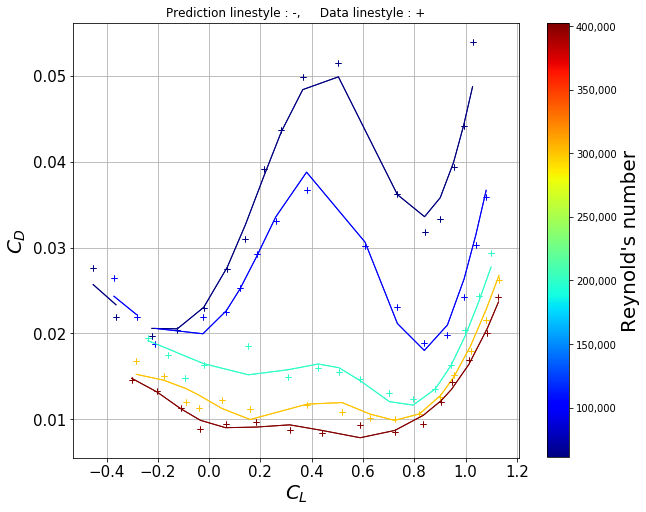

In [15]:
compare_dataframes({"Prediction": pred, "Data":e231}, ycol='Cd',ycolname='$C_D$', xcol='Cl', xcolname="$C_L$", colorbar=True, styles={"Prediction": '-', "Data":'+'});
# # plt.savefig('nn_pred.png', dpi=1000)

In [16]:
CL = np.linspace(-.4, 1.2, 100)
Re = e231_cd.Re.drop_duplicates().values*1.
cl, re = np.meshgrid(CL, Re)
pred = pd.DataFrame.from_dict({
    "Re": re.flatten(),
    "Cl": cl.flatten(),
    "Cd": model(cl.flatten(), re.flatten()).squeeze()
})

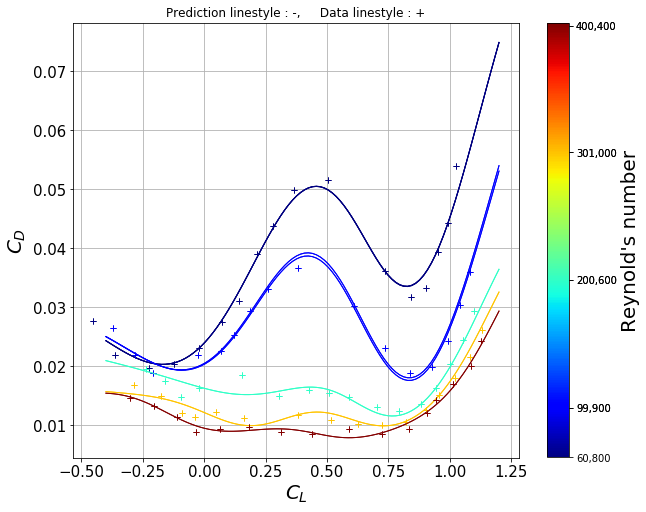

In [17]:
compare_dataframes({"Prediction": pred, "Data":e231}, ycol='Cd',ycolname='$C_D$', xcol='Cl', xcolname="$C_L$", \
colorbar=True, styles={"Prediction": '-', "Data":'+'}, adapt_ticks=True, loglog=False);
# # plt.savefig('nn_e231.png', dpi=100)

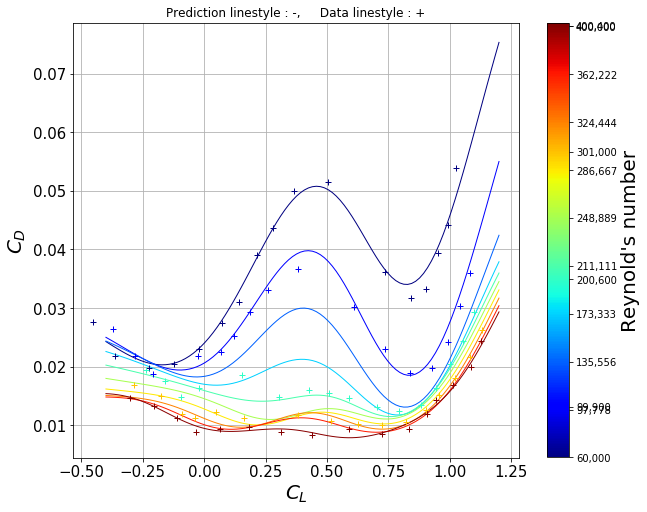

In [18]:
CL = np.linspace(-.4, 1.2, 100)
Re = np.linspace(60000, 400000, 10)
cl, re = np.meshgrid(CL, Re)
pred = pd.DataFrame.from_dict({
    "Re": re.flatten(),
    "Cl": cl.flatten(),
    "Cd": model(cl.flatten(), re.flatten()).squeeze()
})
compare_dataframes({"Prediction": pred, "Data":e231}, ycol='Cd',ycolname='$C_D$', xcol='Cl', xcolname="$C_L$", \
colorbar=True, styles={"Prediction": '-', "Data":'+'}, adapt_ticks=True, loglog=False);
# # plt.savefig('nn_e231.png', dpi=100)

## Plotting contours for fixed CL


In [48]:
CL = torch.linspace(-.5, 1.2, 10)
Re = torch.linspace(70000, 400000, 50)
inp = (torch.stack(torch.meshgrid([CL, Re]), -1).view(-1,2) - inp_mean)/inp_std
inp_data = (inp * inp_std + inp_mean).data
out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "Cl":inp_data[:,0],
    "Cd":out_data[:,0],
    "Re":inp_data[:,1]
})

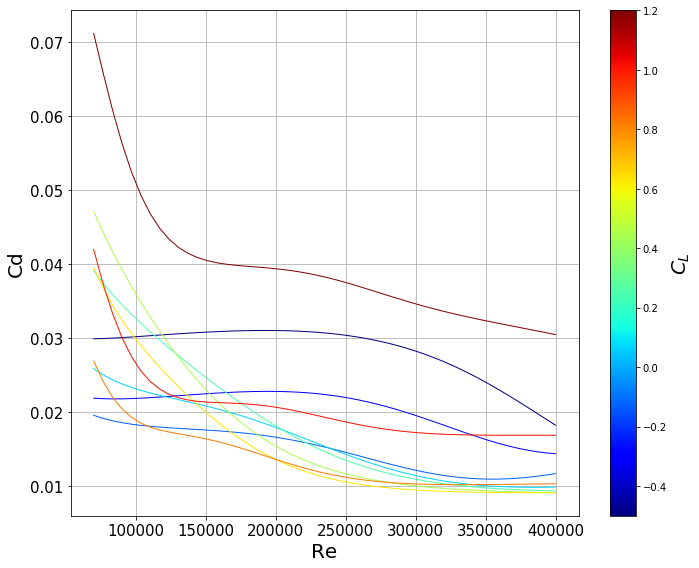

In [49]:
plot_available_data(pred, ycol='Cd', ycolname='Cd', xcol='Re', xcolname='Re', ccol="Cl", ccolname="$C_L$", colorbar=True, style='-');


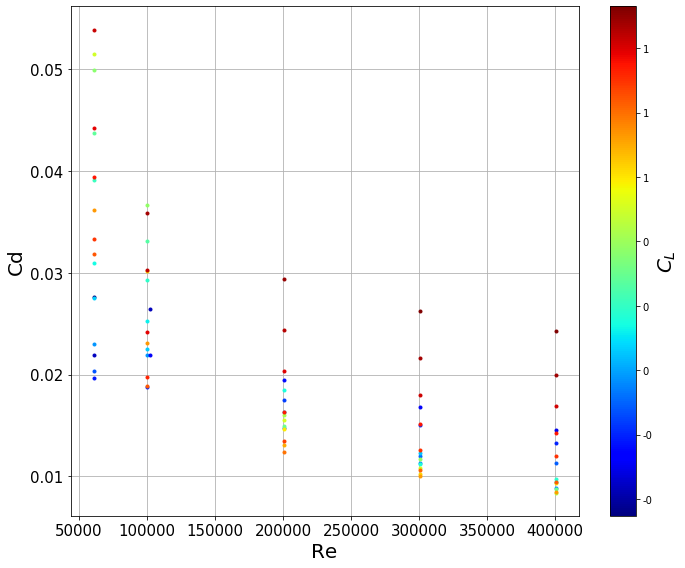

In [27]:
plot_available_data(e231_cd, ycol='Cd', ycolname='Cd', xcol='Re', xcolname='Re', ccol="Cl", ccolname="$C_L$", colorbar=True, style='.');


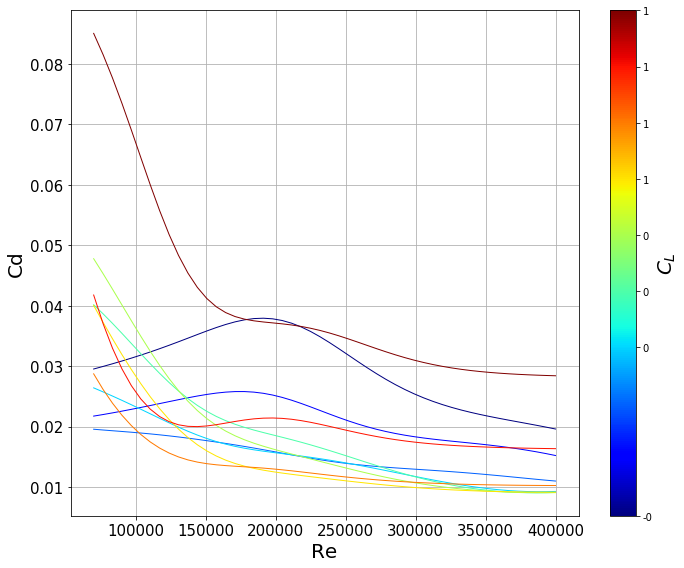

In [28]:
plot_available_data(pred, ycol='Cd', ycolname='Cd', xcol='Re', xcolname='Re', ccol="Cl", ccolname="$C_L$", colorbar=True, style='-', adapt_ticks=True);
